In [5]:

import h5py
import os
import cv2
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import Activation, BatchNormalization
from keras.layers import Activation
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading nifti images
import math
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#from read_data import load_images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.layers import Activation, BatchNormalization

In [6]:
import tensorflow as tf
import keras
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Tensorflow version: 2.16.1
Keras version: 3.0.5


In [7]:
import glob
import numpy as np
import nibabel as nib

def three_to_two(path, label='FALSE'):
    ff = sorted(glob.glob(path + '/*.nii*'))  # Updated file extension pattern
    images = []
    for f in range(len(ff)):
        a = nib.load(ff[f])
        a_data = a.get_fdata()  # Use get_fdata() instead of get_data()
        for i in range(a_data.shape[2]):
            images.append(a_data[:, :, i])
    images = np.asarray(images)
    return images

def min_max_norm(images):
    for i in range(images.shape[0]):
        m = np.max(images[i])
        mi = np.min(images[i])
        images[i] = (images[i] - mi) / (m - mi)
    return images

def label_outliers(img_labels):
    img_labels[img_labels > 1] = 1
    img_labels[img_labels < 0] = 0
    return img_labels

# Image for training
images = three_to_two(path=r'C:\Users\Shantanu\Desktop\projects\tmp_img\img_new')
x_data = min_max_norm(images)

# Labels
img_labels = three_to_two(path=r'C:\Users\Shantanu\Desktop\projects\tmp_img\img_new_label')
y_data = label_outliers(img_labels)

# Test Image
img_test = three_to_two(path=r'C:\Users\Shantanu\Desktop\projects\tmp_img\test_img')
x_test = min_max_norm(img_test)

# Test Labels
label_test = three_to_two(path=r'C:\Users\Shantanu\Desktop\projects\tmp_img\test_img_label')
y_test = label_outliers(label_test)


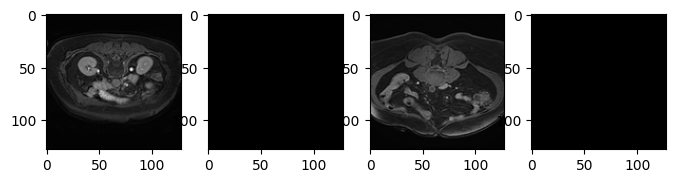

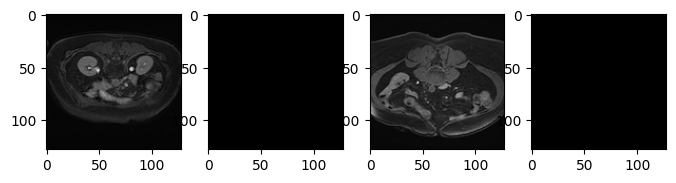

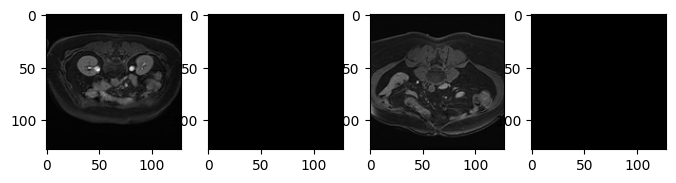

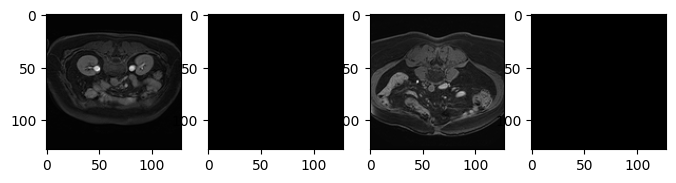

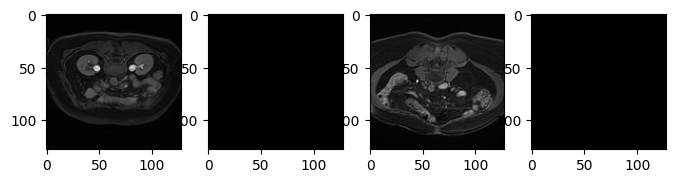

In [8]:
#show 1st 20 slices

for i in range(5):
    fig, ax = plt.subplots(1,4, figsize = (8,4))
    ax[0].imshow(x_data[i], cmap='gray')
    ax[1].imshow(y_data[i], cmap='gray')
    ax[2].imshow(x_test[i], cmap='gray')
    ax[3].imshow(y_test[i], cmap='gray')

plt.show()

In [9]:
x_data = x_data[:,:,:,np.newaxis] # same as reshape (-1,128,128,1)
y_data = y_data[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]
y_test = y_test[:,:,:,np.newaxis]

print('Dimension for training data:', x_data.shape)
print('Dimension for training data labels:', y_data.shape)
print('Dimension for test data:', x_test.shape)
print('Dimension for test data labels:', y_test.shape)

Dimension for training data: (3036, 128, 128, 1)
Dimension for training data labels: (3036, 128, 128, 1)
Dimension for test data: (735, 128, 128, 1)
Dimension for test data labels: (735, 128, 128, 1)


In [10]:
from sklearn.utils import shuffle

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state =42)
x_test, y_test = shuffle(x_test, y_test, random_state= 42)

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + tf.keras.backend.epsilon())

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [12]:
input_layer = Input(shape=x_train.shape[1:]) #Input(shape = (x, y, inChannel))

In [13]:
def conv_block(x_in, filters, batch_norm, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x

def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_block(u, filters, batch_norm)
    merge=concatenate([merge, conv],axis=-1)
    return merge

def Unet_01(input_layer):
    conv1 = conv_block(input_layer, filters=16, batch_norm='TRUE')
    pool1 = pool(conv1)

    conv2 = conv_block(pool1, filters=32, batch_norm='TRUE')
    pool2 = pool(conv2)

    conv3 = conv_block(pool2, filters=32, batch_norm='TRUE')
    pool3 = pool(conv3)

    conv4 = conv_block(pool3, filters=64, batch_norm='TRUE')
    pool4 = pool(conv4)

    conv5 = conv_2d(pool4, filters=128, batch_norm='TRUE')

    up1 = up(conv5,filters=128, merge=conv4, batch_norm='TRUE')
    conv6 = conv_2d(up1, filters=128, batch_norm='TRUE')

    up2 = up(conv6, filters=128, merge=conv3, batch_norm='TRUE')
    conv7 = conv_2d(up2, filters=128, batch_norm='TRUE')

    up3 = up(conv7, filters=64, merge=conv2, batch_norm='TRUE')
    conv8 = conv_2d(up3, filters=64, batch_norm='TRUE')

    up4 = up(conv8, filters=32, merge=conv1, batch_norm='TRUE')
    conv9 = conv_2d(up4, filters=32, batch_norm='TRUE')

    conv10 = conv_2d(conv9, filters=1, batch_norm='FALSE', acti='sigmoid')

    output_layer = conv10
    model = Model(input_layer, output_layer)

    return model

In [14]:
model = Unet_01(input_layer)

In [15]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=42)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=42)
    while True:
        x_batch, _ = data_generator.__next__()
        y_batch, _ = mask_generator.__next__()
        yield x_batch, y_batch

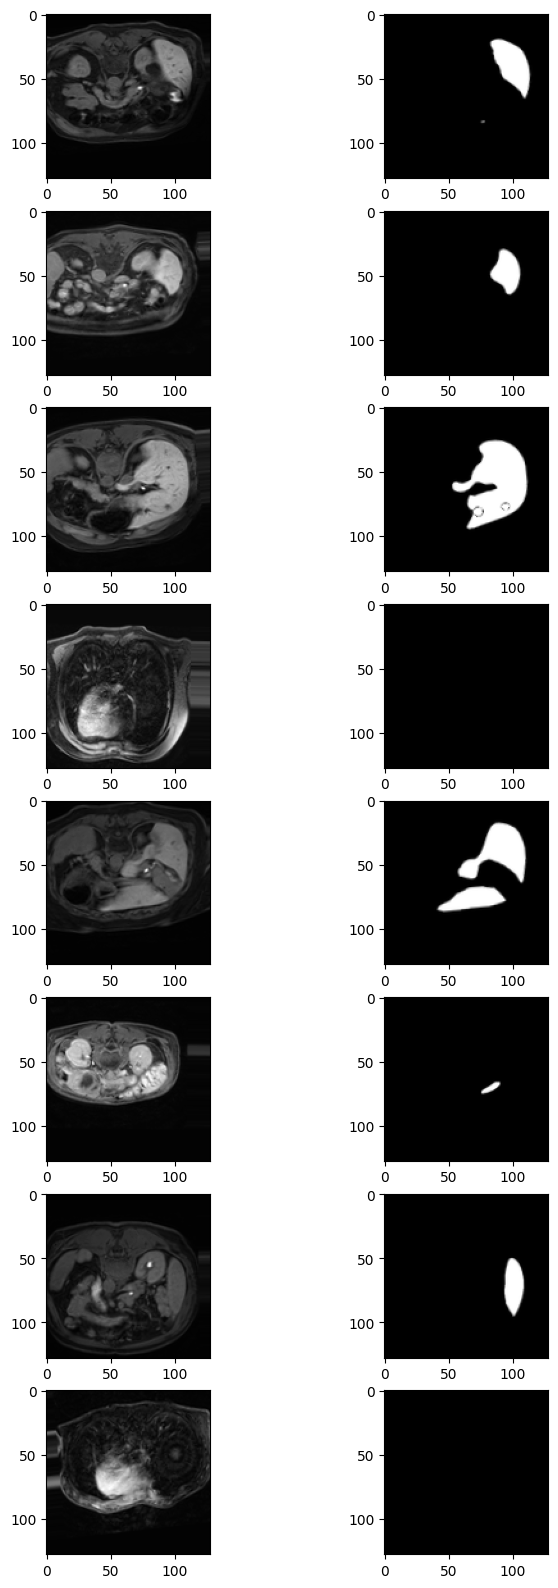

In [16]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap='gray')
plt.show()

In [17]:
model.compile(optimizer=Adam(1e-4), loss= dice_coef_loss, metrics=[dice_coef])

In [18]:
# def steps_per_epoch(sample, batch_size):
#     a = int(np.floor(sample/batch_size))
#     if a<200:
#         return 200
#     else:
#         return a

sample = len(x_data)
batch_size = 64
epochs = 20
steps_per_epoch = 200
#steps_per_epoch = int(np.floor(sample/batch_size))
#steps_per_epoch = steps_per_epoch(sample, batch_size)

print('Step per epoch: ', steps_per_epoch)

Step per epoch:  200


In [19]:
from keras.callbacks import LearningRateScheduler
weight_saver = ModelCheckpoint('seg.weights.h5', monitor='val_dice_coef', save_best_only=True, save_weights_only=True)
lr_decay = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [20]:
from keras.callbacks import TensorBoard
import time

model_dir = 'logs/{}'.format(time.strftime("%H"+"%M"))
tensorboard = TensorBoard(log_dir=model_dir, histogram_freq=epochs, write_graph=True,
                          write_images=True, embeddings_freq=0,
                          embeddings_metadata=None,
                          update_freq='epoch')

write_time = time.strftime("%H"+"%M")

In [26]:
!/opt/bin/nvidia-smi

The system cannot find the path specified.


In [27]:
from keras.callbacks import LearningRateScheduler

from keras.callbacks import ModelCheckpoint

weight_saver = ModelCheckpoint('seg.weights.h5', monitor='val_dice_coef', save_best_only=True, save_weights_only=True)

lr_decay = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

model.compile(optimizer=Adam(1e-4), loss=dice_coef_loss, metrics=[dice_coef])

# Assuming that x_train and y_train are your training data and labels
# and x_val, y_val are your validation data and labels
hist = model.fit(
    my_generator(x_train, y_train, batch_size),
    steps_per_epoch=steps_per_epoch,
    validation_data=(x_val, y_val),
    epochs=epochs,
    verbose=1,
    callbacks=[weight_saver, lr_decay]
)


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1160s 6s/step - dice_coef: 0.7100 - loss: 0.2900 - val_dice_coef: 0.7032 - val_loss: 0.2968 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1029s 5s/step - dice_coef: 0.9415 - loss: 0.0585 - val_dice_coef: 0.9145 - val_loss: 0.0855 - learning_rate: 8.0000e-04
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1036s 5s/step - dice_coef: 0.9524 - loss: 0.0476 - val_dice_coef: 0.9504 - val_loss: 0.0496 - learning_rate: 6.4000e-04
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 954s 5s/step - dice_coef: 0.9560 - loss: 0.0440 - val_dice_coef: 0.9505 - val_loss: 0.0495 - learning_rate: 5.1200e-04
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 980s 5s/step - dice_coef: 0.9582 - loss: 0.0418 - val_dice_coef: 0.9584 - val_loss: 0.0416 - learning_rate: 4.0960e-04
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1344s 7s/step - dice_coef: 0.9607 - loss: 0.0393 - val_dice_coef: 0.9307 - val_loss: 0.0693 - learning_rate: 3.2768e-04
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1343s 

In [28]:
model.compile(optimizer=Adam(1e-4), loss= dice_coef_loss, metrics=[dice_coef])

In [23]:
# Load the weights from the .h5 file
model.load_weights(r'C:\Users\Shantanu\Desktop\projects\model_weights.weights.h5')

In [35]:
print(dice_coef_loss)

<function dice_coef_loss at 0x0000024CD450F880>


In [30]:
import tensorflow as tf
from keras.losses import Loss

class DiceCoefficientLoss(Loss):
    def __init__(self):
        super(DiceCoefficientLoss, self).__init__()

    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + tf.keras.backend.epsilon()) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + tf.keras.backend.epsilon())

    def call(self, y_true, y_pred):
        return 1 - self.dice_coef(y_true, y_pred)


In [31]:
model.compile(optimizer=Adam(1e-4), loss= dice_coef_loss, metrics=[dice_coef])

In [36]:
from keras.models import save_model

save_model(model, 'model_19_04.keras')

In [33]:
# Save the weights
model.save_weights('model_weights.weights.h5')


In [ ]:
from keras.models import load_model
import tensorflow as tf
from keras.losses import Loss

class DiceCoefficientLoss(Loss):
    def __init__(self):
        super(DiceCoefficientLoss, self).__init__()

    def dice_coef(self, y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + tf.keras.backend.epsilon()) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + tf.keras.backend.epsilon())

    def call(self, y_true, y_pred):
        return 1 - self.dice_coef(y_true, y_pred)

# Load the model with custom loss function
model = load_model('model_19_04.keras', custom_objects={'loss':binary_crossentropy ()})


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step


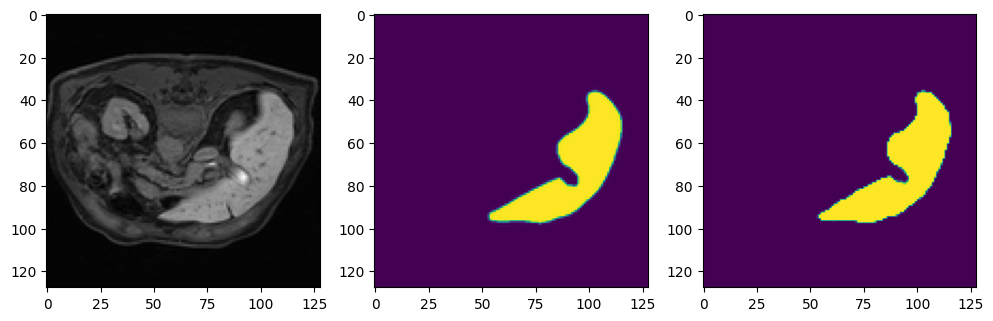

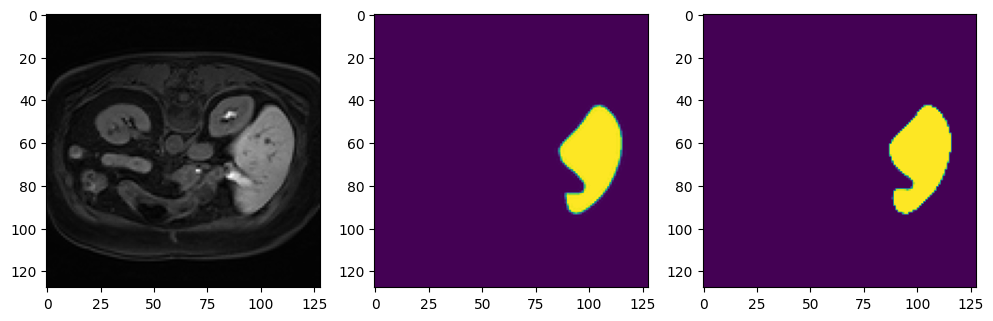

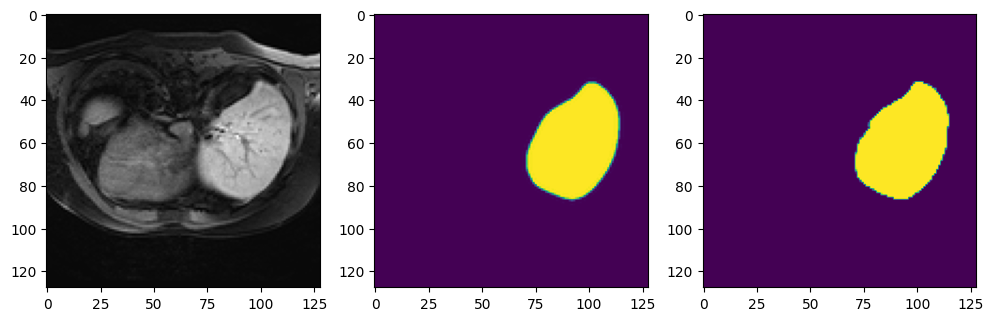

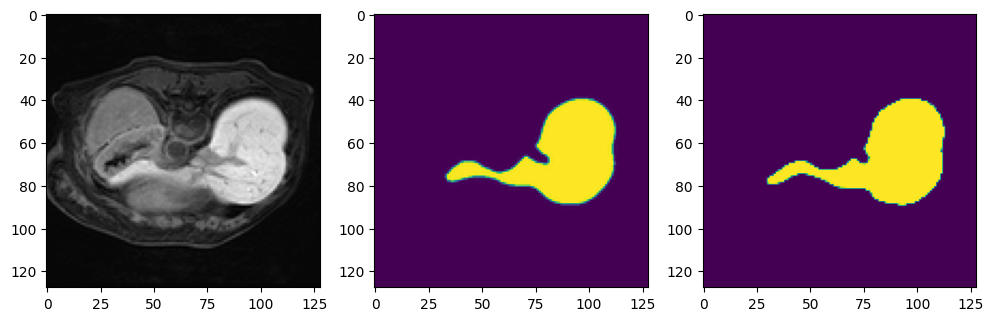

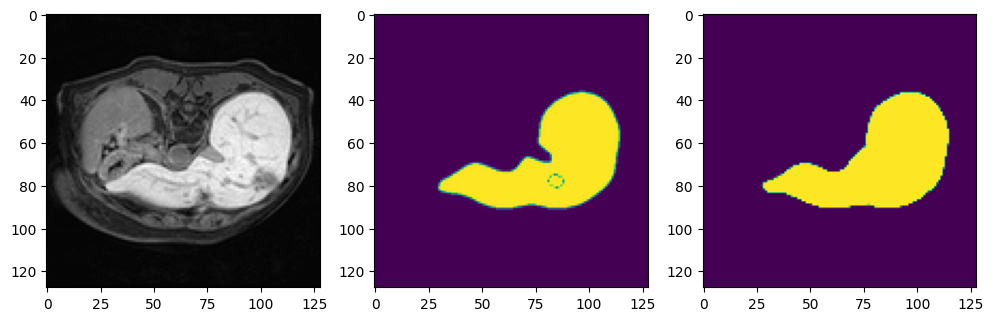

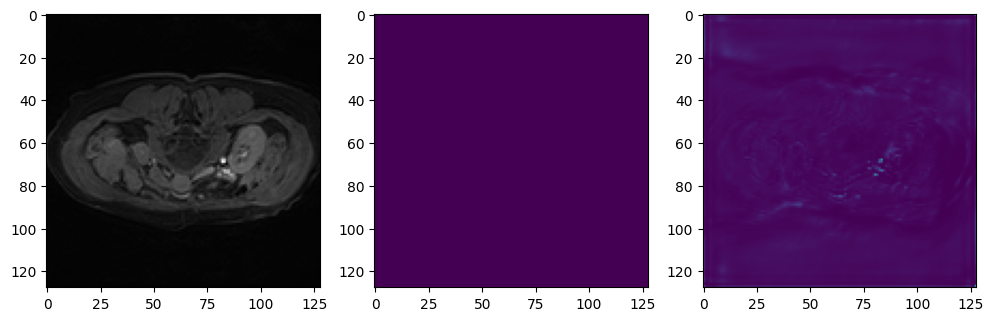

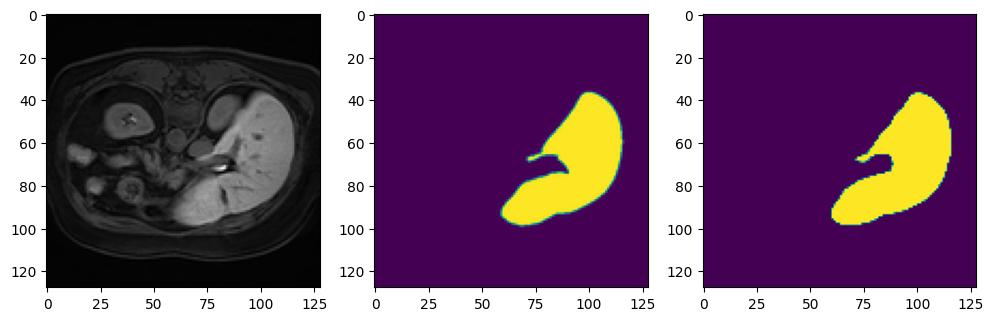

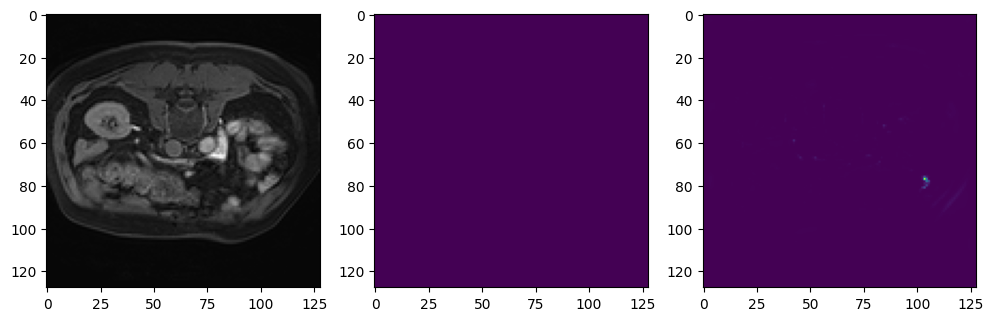

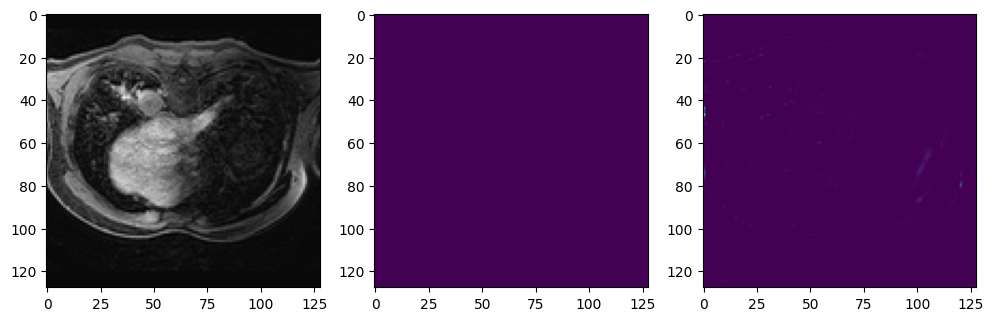

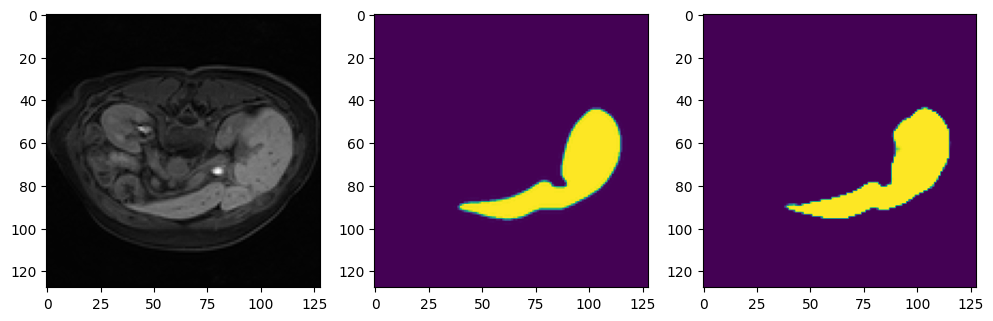

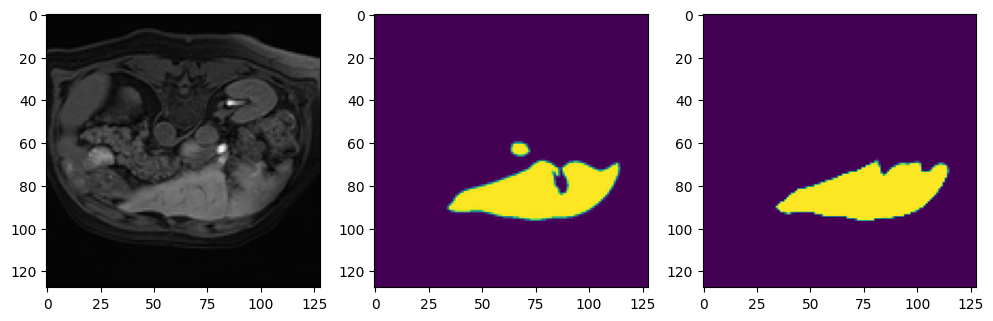

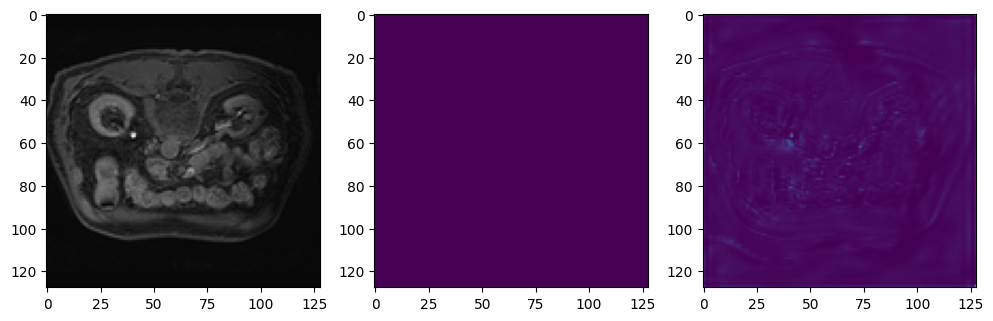

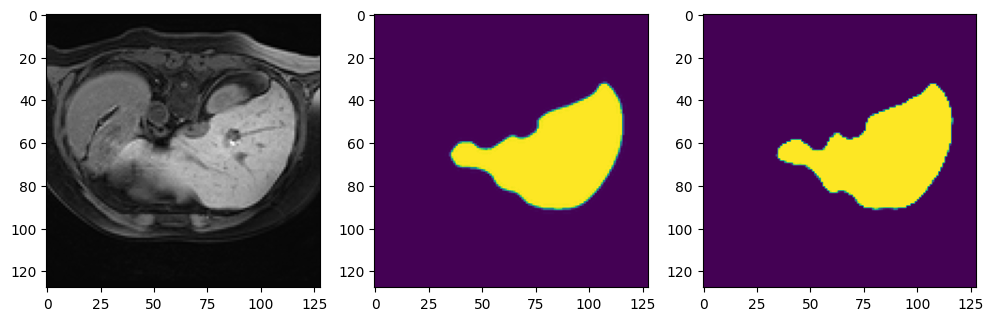

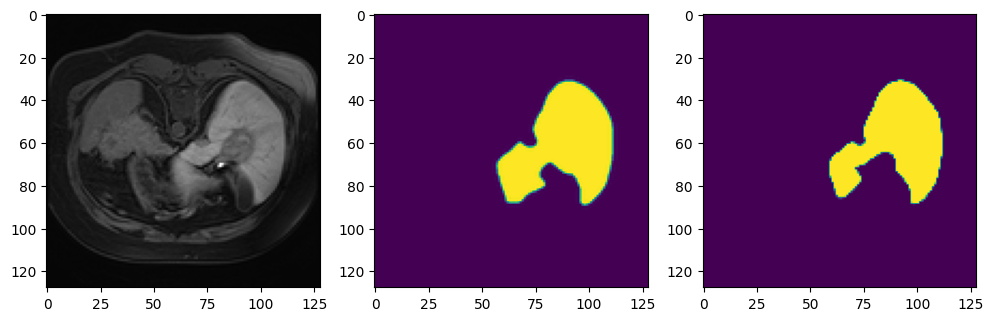

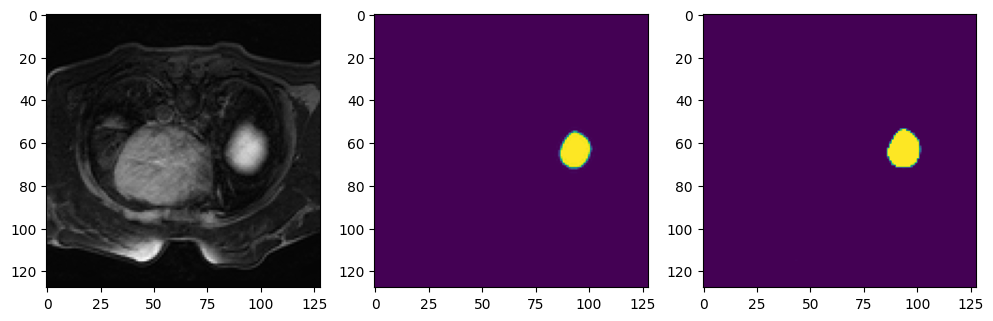

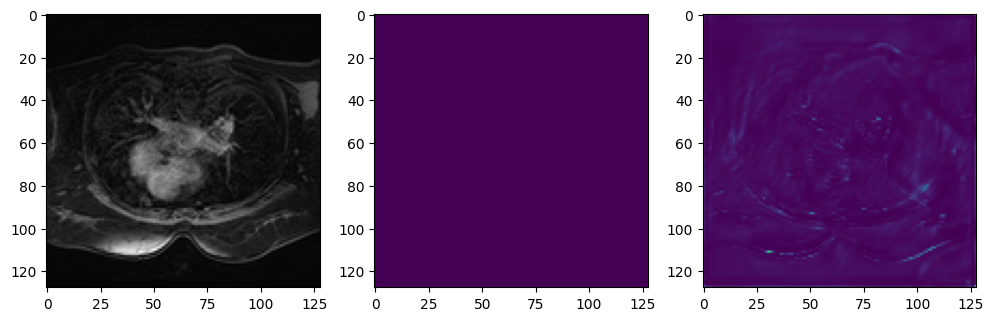

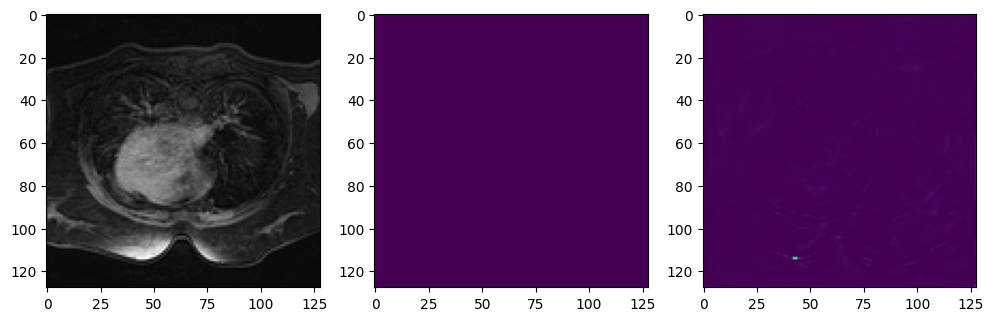

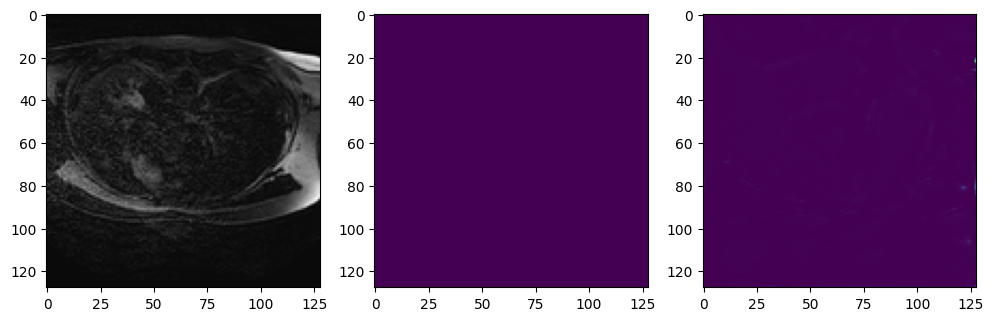

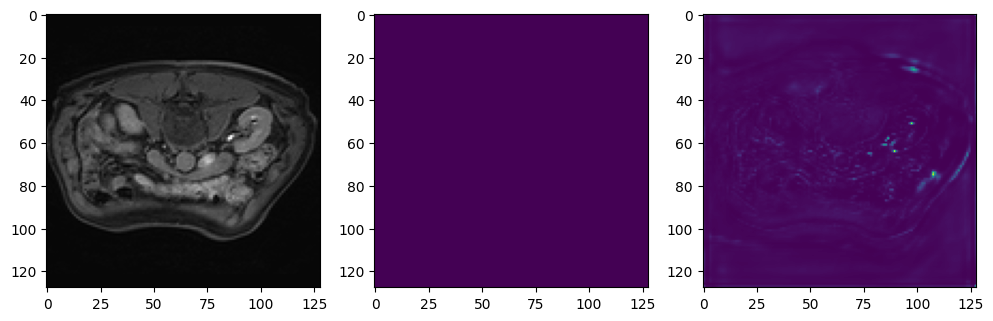

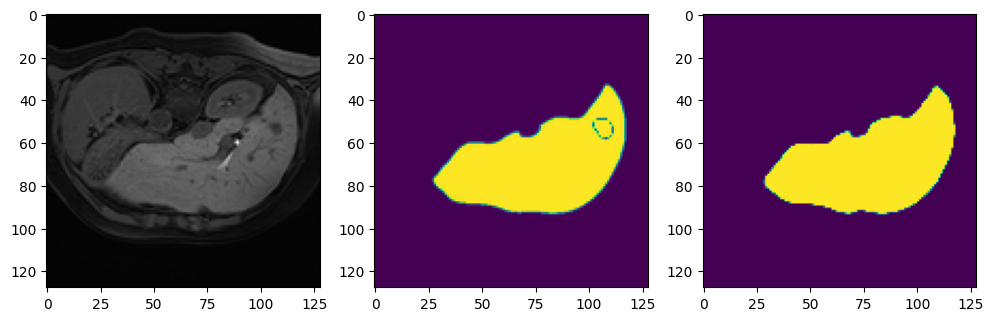

In [26]:
y_pred = model.predict(x_test)
for i in range(0,20,1):
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].imshow(x_test[i,:,:,0], cmap='gray')
    ax[1].imshow(y_test[i,:,:,0], cmap='viridis')
    ax[2].imshow(y_pred[i,:,:,0], cmap='viridis')
plt.show()

In [25]:
test_eval = model.evaluate(x_test, y_test, verbose=1, batch_size = batch_size)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 779ms/step - dice_coef: 0.9527 - loss: 0.0473
Test loss: 0.046427611261606216
Test accuracy: 0.9535723328590393


In [ ]:
model.summary()

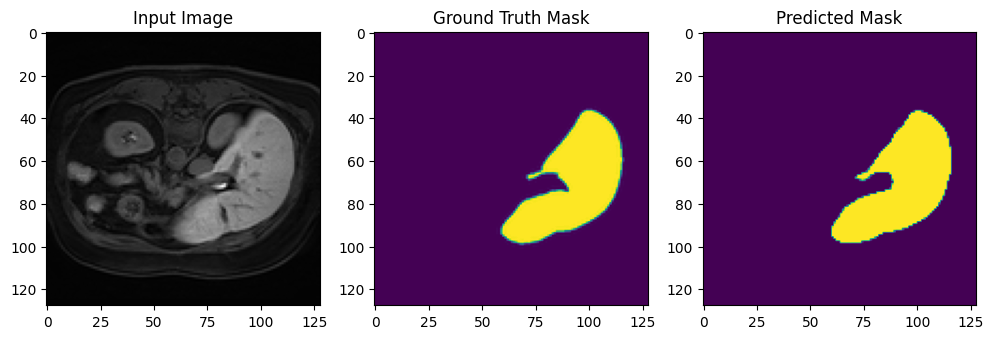

In [33]:
import matplotlib.pyplot as plt

def show_prediction(index, x_test, y_test, y_pred):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(x_test[index, :, :, 0], cmap='gray')
    ax[0].set_title('Input Image')
    ax[1].imshow(y_test[index, :, :, 0], cmap='viridis')
    ax[1].set_title('Ground Truth Mask')
    ax[2].imshow(y_pred[index, :, :, 0], cmap='viridis')
    ax[2].set_title('Predicted Mask')
    plt.show()

# Display prediction for the first image
show_prediction(6, x_test, y_test, y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


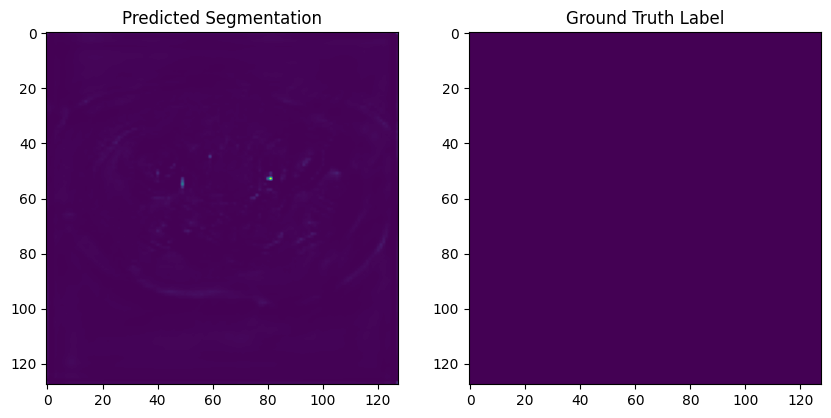

In [46]:
import numpy as np
import nibabel as nib  # for handling NIfTI files
from keras.models import load_model
import cv2  # for image preprocessing
import matplotlib.pyplot as plt  # for visualization
from sklearn.metrics import accuracy_score

#architecture
def conv_block(x_in, filters, batch_norm, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm=='TRUE':
        x = BatchNormalization()(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm=='TRUE':
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x

def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_block(u, filters, batch_norm)
    merge=concatenate([merge, conv],axis=-1)
    return merge

def Unet_01(input_layer):
    conv1 = conv_block(input_layer, filters=16, batch_norm='TRUE')
    pool1 = pool(conv1)

    conv2 = conv_block(pool1, filters=32, batch_norm='TRUE')
    pool2 = pool(conv2)

    conv3 = conv_block(pool2, filters=32, batch_norm='TRUE')
    pool3 = pool(conv3)

    conv4 = conv_block(pool3, filters=64, batch_norm='TRUE')
    pool4 = pool(conv4)

    conv5 = conv_2d(pool4, filters=128, batch_norm='TRUE')

    up1 = up(conv5,filters=128, merge=conv4, batch_norm='TRUE')
    conv6 = conv_2d(up1, filters=128, batch_norm='TRUE')

    up2 = up(conv6, filters=128, merge=conv3, batch_norm='TRUE')
    conv7 = conv_2d(up2, filters=128, batch_norm='TRUE')

    up3 = up(conv7, filters=64, merge=conv2, batch_norm='TRUE')
    conv8 = conv_2d(up3, filters=64, batch_norm='TRUE')

    up4 = up(conv8, filters=32, merge=conv1, batch_norm='TRUE')
    conv9 = conv_2d(up4, filters=32, batch_norm='TRUE')

    conv10 = conv_2d(conv9, filters=1, batch_norm='FALSE', acti='sigmoid')

    output_layer = conv10
    model = Model(input_layer, output_layer)

    return model

input_layer = Input(shape=x_train.shape[1:]) #Input(shape = (x, y, inChannel))

model = Unet_01(input_layer)

model.compile(optimizer=Adam(1e-4), loss= dice_coef_loss, metrics=[dice_coef])


# Load the weights from the .h5 file
model.load_weights(r'C:\Users\Shantanu\Desktop\projects\model_weights.weights.h5')

# Function to preprocess the NIfTI image
def preprocess_image(image_path):
    # Read the NIfTI image
    nii_img = nib.load(image_path)
    # Get the image data array
    image_data = nii_img.get_fdata()

    # Convert to grayscale if multi-channel
    if image_data.shape[-1] > 1:
        # Assuming the last dimension represents channels, take the first channel
        image_data = image_data[..., 0]

    # Resize the image to match the input size of the model (128x128)
    resized_image = cv2.resize(image_data, (128, 128), interpolation=cv2.INTER_LINEAR)

    # Normalize pixel values to [0, 1]
    normalized_image = resized_image / np.max(resized_image)

    # Expand dimensions to match the model's input shape
    preprocessed_image = np.expand_dims(normalized_image, axis=-1)
    
    return preprocessed_image

# Function to perform prediction
def predict_image_with_label(image_path, label_path):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    
    # Perform prediction
    prediction = model.predict(preprocessed_image[np.newaxis, ...])

    # Read the label
    label = nib.load(label_path).get_fdata()
    
    return prediction, label

# Example usage
image_path = r'C:\Users\Shantanu\Desktop\projects\tmp_img\img_new\0.nii.gz'
label_path = r'C:\Users\Shantanu\Desktop\projects\tmp_img\img_new_label\label_0.nii.gz'
prediction, label = predict_image_with_label(image_path, label_path)

# Visualize the prediction
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(prediction[0, :, :, 0])
plt.title('Predicted Segmentation')

plt.subplot(1, 2, 2)
plt.imshow(label[:, :, 0])
plt.title('Ground Truth Label')

plt.show()
